In [1]:
%matplotlib inline

In [13]:
#export
from export.nb_01 import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

pd.pandas.set_option('display.max_columns', None)

In [56]:
#export
def files(path):
    return [f.name for f in os.scandir(path)]

Path.ls= files

In [34]:
path_tabdata=Path(r'D:\datasets\new_datasets')
path_tabdata.ls()

['caterpillar-tube-pricing',
 'costa-rican-household-poverty-prediction',
 'flavours-of-physics-kernels-only',
 'higgs-boson',
 'leaf-classification',
 'mercedes-benz-greener-manufacturing',
 'msk-redefining-cancer-treatment',
 'MusicHackathon',
 'nomad2018-predict-transparent-conductors',
 'porto-seguro-safe-driver-prediction',
 'predict-west-nile-virus',
 'predict-who-is-more-influential-in-a-social-network',
 'random-acts-of-pizza',
 'recruit-restaurant-visitor-forecasting',
 'sberbank-russian-housing-market',
 'spooky-author-identification',
 'whats-cooking']

In [35]:
path_house=path_tabdata/'sberbank-russian-housing-market'
path_house.ls()

['data_dictionary.txt',
 'macro.csv.zip',
 'New folder',
 'sample_submission.csv.zip',
 'test.csv',
 'train.csv',
 '__MACOSX']

In [36]:
path_house_train=path_house/'train.csv'
path_house_test=path_house/'test.csv'

In [37]:
df_train=pd.read_csv(path_house_train, index_col='id', parse_dates=['timestamp'], infer_datetime_format=True)
df_train.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [38]:
#export
def add_datepart(df:pd.DataFrame, cols:list=None, just_date:bool=True,inplace:bool=True)->pd.DataFrame:
    '''parameters:
                df: pd.DataFrame
                cols: datetime cols
                just date: bool specifying whether the object is it just date or date time
                inplace: bool'''
    date_part=['year','month','day','week','dayofweek','weekday','quarter','is_month_start','is_month_end','is_year_end']
    time_part=['time','hour','minute','second']
    for i in cols:
        if not just_date:
            for j in time_part:
                df[f'{i}_{j}']=getattr(df[i].dt,j)
        for j in date_part:
            df[f'{i}_{j}']=getattr(df[i].dt,j)
    df.drop(columns=cols, inplace=True)
    return 

In [39]:
add_datepart(df_train, ['timestamp'])

In [40]:
discrete = [var for var in df_train.columns if df_train[var].dtype!='O' and var!='price_doc' and df_train[var].nunique()<10]
continuous = [var for var in df_train.columns if df_train[var].dtype!='O' and var!='price_doc' and var not in discrete]
categorical = [var for var in df_train.columns if df_train[var].dtype=='O']

In [41]:
len(discrete), len(continuous), len(categorical)

(29, 255, 15)

In [42]:
#export
def split_val(df:pd.DataFrame, val_pct:float=0.3):
    'returns `df_train` and `df_valid`'
    shuf_idx=np.random.permutation(len(df))
    train_idx, val_idx=shuf_idx[int(val_pct*len(df)):], shuf_idx[:int(val_pct*len(df))]
    return df.iloc[train_idx,:], df.iloc[val_idx,:]
    
def split_dep_col(df:pd.DataFrame, y:str):
    'returns `x` and `y`'
    return df.drop(columns=y), df.loc[:, y]
    
def split_test_val(df:pd.DataFrame, y:str, val_pct:float=0.3):
    ''' df 'pandas datadrame object `y` is the dependent column val_pct:=0.3'
    returns `x_train`, `y_train`, `x_valid`, `y_valid`'''
    df_train, df_val= split_val(df, val_pct)
    return split_dep_col(df_train, y), split_dep_col(df_val, y)

In [43]:
(x_train, y_train), (x_val, y_val)= split_test_val(df_train, y='price_doc')

In [44]:
#export
def check_missing(df:pd.DataFrame, top:int=10):
    return pd.DataFrame(df.isna().mean()).sort_values(by=0, ascending=False)[:top]

In [45]:
check_missing(x_train[continuous])

,0
hospital_beds_raion,0.475059
build_year,0.446648
cafe_sum_500_min_price_avg,0.437787
cafe_sum_500_max_price_avg,0.437787
cafe_avg_price_500,0.437787
max_floor,0.313971
num_room,0.313971
kitch_sq,0.313971
preschool_quota,0.221097
school_quota,0.220956


In [46]:
x_cont_miss=check_missing(x_train[continuous])
cont_mis=list(x_cont_miss[x_cont_miss[0]>0].index)

In [47]:
check_missing(x_train[discrete])

,0
state,0.445195
material,0.313971
build_count_foam,0.165401
build_count_mix,0.165401
mosque_count_1500,0.000000
timestamp_is_month_end,0.000000
timestamp_is_month_start,0.000000
timestamp_quarter,0.000000
timestamp_weekday,0.000000
timestamp_dayofweek,0.000000


In [48]:
discrete_mis=['state','material','build_count_foam','build_count_mix']

In [49]:
check_missing(x_train[categorical])

,0
product_type,0.0
sub_area,0.0
culture_objects_top_25,0.0
thermal_power_plant_raion,0.0
incineration_raion,0.0
oil_chemistry_raion,0.0
radiation_raion,0.0
railroad_terminal_raion,0.0
big_market_raion,0.0
nuclear_reactor_raion,0.0


In [50]:
x_train

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

Text(0, 0.5, 'mean House price')

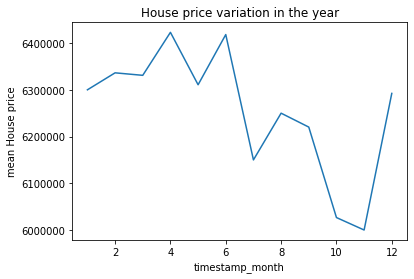

In [51]:
df_train.groupby('timestamp_month')['price_doc'].median().plot()
plt.title('House price variation in the year')
plt.ylabel('mean House price')

In [52]:
len(discrete), len(categorical)

(29, 15)

In [58]:
#export
class Tabular:
    def __init__(self, df_train:pd.DataFrame, df_val:pd.DataFrame , cat_cols:list=[], num_cols:list=[]):
        self.df_train=df_train.copy()
        self.df_val=df_val.copy()
        self.cat_cols=cat_cols
        self.num_cols=num_cols
        self.cat_col_dict={}
        self.rev_cat={}
        
    def conv_cat(self):
        for i in self.cat_cols:
            self.cat_col_dict[i]={k: j for j, k in enumerate(self.df_train[i].unique())}
            self.df_train[i].replace(self.cat_col_dict[i])
            self.df_val[i].replace(self.cat_col_dict[i])
            
    def impute_mean(self):
        self.mean_impute_dict={}
        for i in self.num_cols:
            self.mean_impute_dict[i]=self.df_train[i].mean()
            self.impute_na(self.df_train, i, self.mean_impute_dict[i])
            self.impute_na(self.df_val, i, self.mean_impute_dict[i])
            
    def impute_median(self):
        self.median_impute_dict={}
        for i in self.num_cols:
            self.median_impute_dict[i]=self.df_train[i].median()
            self.impute_na(self.df_train, i, self.median_impute_dict[i])
            self.impute_na(self.df_val, i, self.median_impute_dict[i])
            
    def impute_na(self, df:pd.DataFrame, col:str, value):
        df[col].fillna(value, inplace=True)
            
    def encode_disc(self):
        for i in self.dis_cols:
            df[i]=pd.qcut(df[i], 4)
    
    def ret_cat_codes(self):
        for i in self.cat_cols:
            self.df_train[i]=self.df_train[i].replace(self.cat_col_dict[i])
            self.impute_na(self.df_train, i, len(self.cat_col_dict[i])+1)
            self.df_val[i]=self.df_val[i].replace(self.cat_col_dict[i]) # dict(map(reversed, my_map.items()))
            self.impute_na(self.df_val, i, len(self.cat_col_dict[i])+1)

In [59]:
#export
def proc_df(df_tr:pd.DataFrame, df_va:pd.DataFrame, cat_cols:list, num_cols:list):
    data=Tabular(df_tr, df_va, cat_cols=cat_cols, num_cols=num_cols)
    data.impute_mean()
    data.conv_cat()
    data.ret_cat_codes()
    return data

In [60]:
data=proc_df(x_train, x_val, cat_cols=categorical+discrete, num_cols=continuous)

In [61]:
x_train

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

In [62]:
data.df_train

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

In [64]:
def norm_max_min(df_train, df_val):
    res_train, res_val = df_train.copy(), df_val.copy()
    for feature_name in df_train.columns:
        max_value = df_train[feature_name].max()
        min_value = df_train[feature_name].min()
        res_train[feature_name] = (df_train[feature_name] - min_value) / (max_value - min_value)
        res_val[feature_name]= (df_val[feature_name]-min_value/ (max_value-min_value))
    return res_train, res_val

In [70]:
#export
def normalize(df_train, df_val):
    res_train, res_val= df_train.copy(), data.df_val.copy()
    for feature_name in res_train.columns:
        mean_train=res_train[feature_name].mean()
        std_train=res_train[feature_name].std
        res_train[feature_name]=(res_train[feature_name]-mean_train)/std_train
        res_val[feature_name]=(res_val[feature_name]-mean_train)/std_train
    return res_train, res_val

In [71]:
normalize(x_train, x_val)

TypeError: <class 'method'>

In [66]:
preds=clf.predict(X_val)

NameError: name 'clf' is not defined

In [67]:
r2_score(y_val, preds)

NameError: name 'r2_score' is not defined

In [68]:
y_val[:10], preds[:10]

NameError: name 'preds' is not defined

In [69]:
from sklearn.ensemble import RandomForestRegressor

ModuleNotFoundError: No module named 'sklearn'

In [299]:
regr = RandomForestRegressor(max_depth=3, random_state=0)
regr.fit(X_train, y_train)
preds=regr.predict(X_val)
r2_score(y_val, preds)

-26.1997974514665

In [300]:
y_val[:10], preds[:10]

(id
 7726     12640380
 14920    20500000
 18669    14000000
 22009     7000000
 29603     1000000
 25546     4641000
 23814     5756303
 9332      6500000
 13947     5400000
 3653      5500000
 Name: price_doc, dtype: int64,
 array([33595172.90340298, 33595172.90340298, 33595172.90340298,
        32955842.97149104, 31824090.21802514, 28483994.76756088,
        11264449.11355723, 33595172.90340298, 32838501.25733667,
        31824090.21802514]))

In [57]:
preds.std(), y_val.std()

NameError: name 'preds' is not defined